In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

In [23]:
data = pd.read_csv(r"C:\Users\a0083\OneDrive\Desktop\SP Multivariados\distancias_a_refineria.csv")
df = pd.DataFrame(data)

In [24]:
df.dtypes

station          object
lat             float64
lon             float64
elev_m            int64
distance_km     float64
delta_elev_m      int64
dtype: object

In [25]:
df.head()

,station,lat,lon,elev_m,distance_km,delta_elev_m
0,SE3,25.601111,-99.999167,334,5.6673,-26
1,SE2,25.645833,-100.095278,387,16.4081,27
2,NE3,25.790556,-100.078333,346,26.1374,-14
3,SE,25.665278,-100.243611,500,31.1865,140
4,NE2,25.777222,-100.188056,432,32.1738,72


Escalamiento de la variable

In [26]:
X = df[["distance_km"]].values
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

WARD MULTIVARIADO (variables espaciales/físicas escaladas)

Idea: construir un vector de características por estación que combine:
 - Coordenadas (en km): X_km, Y_km (derivadas de lat/lon)
 - Elevación y delta de elevación (en km)
 - Distancia radial a la refinería (distance_km)
 - Luego estandarizar y aplicar Ward (euclidiana) -> dendrograma.

In [27]:
# Conversión local lat/lon -> km (aprox. Monterrey ~ 25.7°N)
lat0 = df["lat"].mean()
km_per_deg_lat = 111.32               # ~111.32 km por grado de latitud
km_per_deg_lon = 111.32*np.cos(np.radians(lat0))  # ~100 km por grado de longitud en Mty

In [28]:
# Re-centrar y convertir a km (para que la euclidiana sea coherente espacialmente)
df["X_km"] = (df["lon"] - df["lon"].mean()) * km_per_deg_lon
df["Y_km"] = (df["lat"] - df["lat"].mean()) * km_per_deg_lat

In [29]:
# Pasar elevaciones a km para que su escala sea comparable con distancia_km
df["elev_km"] = df["elev_m"] / 1000.0
df["delta_elev_km"] = df["delta_elev_m"] / 1000.0

In [ ]:
cand_features = ["X_km", "Y_km", "elev_km", "delta_elev_km", "distance_km"]
features = [c for c in cand_features if c in df.columns]

# Estandarizar y Ward
X = df[features].to_numpy()
Xz = StandardScaler().fit_transform(X)

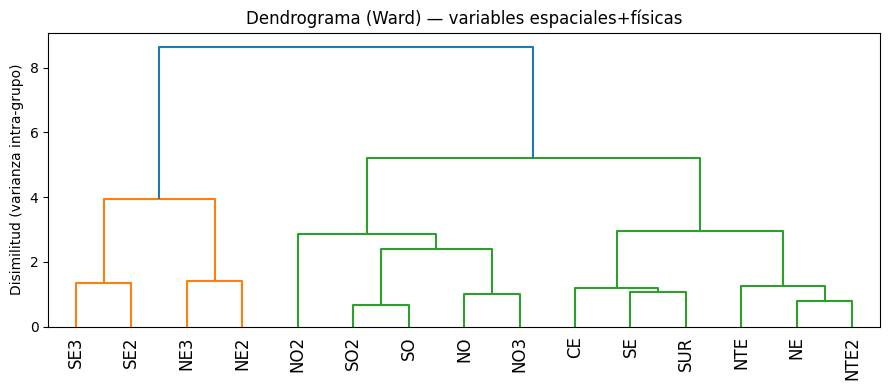

,station,distance_km,cluster_ward_multi,X_km,Y_km,elev_km,delta_elev_km
0,SE3,5.6673,1,29.470181,-12.624519,0.334,-0.026
1,SE2,16.4081,1,19.830665,-7.646066,0.387,0.027
2,NE3,26.1374,1,21.530175,8.464498,0.346,-0.014
3,SE,31.1865,3,4.953509,-5.481449,0.500,0.140
4,NE2,32.1738,1,10.525434,6.980157,0.432,0.072
5,SUR,33.1970,3,1.916757,-10.861990,0.555,0.195
6,NE,35.4650,3,4.006216,3.362257,0.474,0.114
7,NTE2,39.8585,3,-1.705020,1.692457,0.520,0.160
8,CE,40.6682,3,-4.546696,-4.306466,0.562,0.202
9,NTE,44.8991,3,-3.432311,9.361181,0.503,0.143


In [40]:

Z_ward_multi = linkage(Xz, method="ward")

plt.figure(figsize=(9,4))
dendrogram(Z_ward_multi, labels=df["station"].tolist(), leaf_rotation=90)
plt.title("Dendrograma (Ward) — variables espaciales+físicas")
plt.ylabel("Disimilitud (varianza intra-grupo)")
plt.tight_layout(); plt.show()

# 6) Etiquetas de clúster 
k = 3
df["cluster_ward_multi"] = fcluster(Z_ward_multi, k, criterion="maxclust")

cols_to_show = ["station"]
if "distance_km" in df.columns:
    cols_to_show.append("distance_km")
cols_to_show.append("cluster_ward_multi")
cols_to_show += [c for c in features if c not in cols_to_show]

out_ward = df[cols_to_show]
if "distance_km" in out_ward.columns:
    out_ward = out_ward.sort_values("distance_km")

out_ward

Complete/Average con distancia geofísica (con fixes)

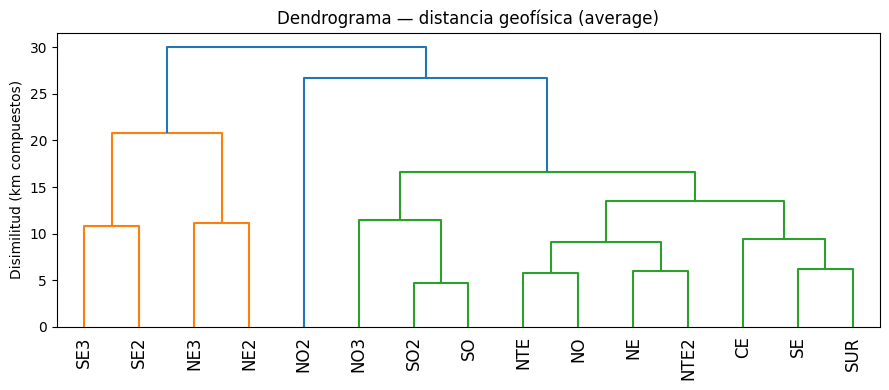

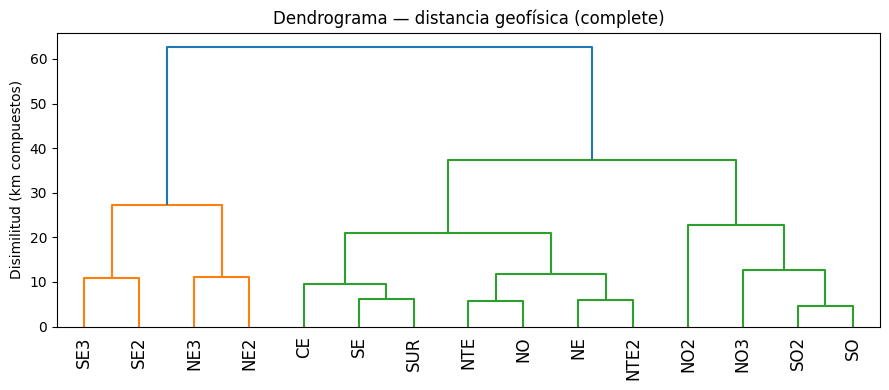

,station,distance_km,cluster_ward_multi,cluster_geo_avg,cluster_geo_compl
0,SE3,5.6673,1,1,1
1,SE2,16.4081,1,1,1
2,NE3,26.1374,1,1,1
3,SE,31.1865,3,2,2
4,NE2,32.1738,1,1,1
5,SUR,33.1970,3,2,2
6,NE,35.4650,3,2,2
7,NTE2,39.8585,3,2,2
8,CE,40.6682,3,2,2
9,NTE,44.8991,3,2,2


In [ ]:
# DISTANCIA GEOFÍSICA (lat/lon/elevación) + clustering jerárquico (average, complete)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import numpy as np
import matplotlib.pyplot as plt

# Haversine (km)
def haversine_vec(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1, p2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlmb = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlmb/2.0)**2
    return 2*R*np.arcsin(np.sqrt(a))

coords = df[["lat","lon"]].to_numpy()
elev_km = (df["elev_m"].to_numpy() / 1000.0).reshape(-1,1)

n = len(df)
D = np.zeros((n,n), dtype=float)

# Peso de elevación (ajústalo si quieres)
w = 5.0

for i in range(n):
    for j in range(i+1, n):
        ground = haversine_vec(coords[i,0], coords[i,1], coords[j,0], coords[j,1])
        delev = abs(elev_km[i,0] - elev_km[j,0])
        Dij = np.sqrt(ground**2 + (w*delev)**2)
        D[i,j] = D[j,i] = Dij

# Average
Z_avg = linkage(squareform(D), method="average")
plt.figure(figsize=(9,4))
dendrogram(Z_avg, labels=df["station"].tolist(), leaf_rotation=90)
plt.title("Dendrograma — distancia geofísica (average)")
plt.ylabel("Disimilitud (km compuestos)")
plt.tight_layout(); plt.show()

df["cluster_geo_avg"] = fcluster(Z_avg, 3, criterion="maxclust")

# Complete
Z_compl = linkage(squareform(D), method="complete")
plt.figure(figsize=(9,4))
dendrogram(Z_compl, labels=df["station"].tolist(), leaf_rotation=90)
plt.title("Dendrograma — distancia geofísica (complete)")
plt.ylabel("Disimilitud (km compuestos)")
plt.tight_layout(); plt.show()

df["cluster_geo_compl"] = fcluster(Z_compl, 3, criterion="maxclust")

df[["station", "distance_km", "cluster_ward_multi", "cluster_geo_avg", "cluster_geo_compl"]]


Resultados

In [35]:
# Conteos por clúster
print("Ward multivariado:")
print(df["cluster_ward_multi"].value_counts().sort_index(), "\n")

print("Geo (average):")
print(df["cluster_geo_avg"].value_counts().sort_index(), "\n")

print("Geo (complete):")
print(df["cluster_geo_compl"].value_counts().sort_index(), "\n")

# Tabla resumen principal
cols_base = ["station","lat","lon","distance_km",
             "cluster_ward_multi","cluster_geo_avg","cluster_geo_compl"]
display(df[cols_base].sort_values("distance_km"))


Ward multivariado:
cluster_ward_multi
1    4
2    5
3    6
Name: count, dtype: int64 

Geo (average):
cluster_geo_avg
1     4
2    10
3     1
Name: count, dtype: int64 

Geo (complete):
cluster_geo_compl
1    4
2    7
3    4
Name: count, dtype: int64 



,station,lat,lon,distance_km,cluster_ward_multi,cluster_geo_avg,cluster_geo_compl
0,SE3,25.601111,-99.999167,5.6673,1,1,1
1,SE2,25.645833,-100.095278,16.4081,1,1,1
2,NE3,25.790556,-100.078333,26.1374,1,1,1
3,SE,25.665278,-100.243611,31.1865,3,2,2
4,NE2,25.777222,-100.188056,32.1738,1,1,1
5,SUR,25.616944,-100.273889,33.1970,3,2,2
6,NE,25.744722,-100.253056,35.4650,3,2,2
7,NTE2,25.729722,-100.310000,39.8585,3,2,2
8,CE,25.675833,-100.338333,40.6682,3,2,2
9,NTE,25.798611,-100.327222,44.8991,3,2,2


In [36]:
import pandas as pd
from sklearn.metrics import adjusted_rand_score

# Ward vs Geo-average
ct_avg = pd.crosstab(df["cluster_ward_multi"], df["cluster_geo_avg"])
ari_avg = adjusted_rand_score(df["cluster_ward_multi"], df["cluster_geo_avg"])
print("Contingencia Ward vs Geo-Average:\n", ct_avg, "\nARI =", round(ari_avg, 3), "\n")

# Ward vs Geo-complete
ct_compl = pd.crosstab(df["cluster_ward_multi"], df["cluster_geo_compl"])
ari_compl = adjusted_rand_score(df["cluster_ward_multi"], df["cluster_geo_compl"])
print("Contingencia Ward vs Geo-Complete:\n", ct_compl, "\nARI =", round(ari_compl, 3))


Contingencia Ward vs Geo-Average:
 cluster_geo_avg     1  2  3
cluster_ward_multi         
1                   4  0  0
2                   0  4  1
3                   0  6  0 
ARI = 0.46 

Contingencia Ward vs Geo-Complete:
 cluster_geo_compl   1  2  3
cluster_ward_multi         
1                   4  0  0
2                   0  1  4
3                   0  6  0 
ARI = 0.775


In [38]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist, squareform
import numpy as np

# --- Ward multivariado ---
D_euc = pdist(Xz, metric="euclidean")                       # vector condensado
sil_ward = silhouette_score(Xz, df["cluster_ward_multi"], metric="euclidean")
coph_ward, _ = cophenet(Z_ward_multi, D_euc)
print(f"Silhouette (Ward multi): {sil_ward:.3f} | Cophenética (Ward): {coph_ward:.3f}")

# --- Geo average ---
# OJO: Aquí usa la MATRIZ D n×n (no squareform)
sil_geo_avg = silhouette_score(D, df["cluster_geo_avg"], metric="precomputed")
coph_geo_avg, _ = cophenet(Z_avg, squareform(D))            # aquí sí va condensado
print(f"Silhouette (Geo avg): {sil_geo_avg:.3f} | Cophenética (Geo avg): {coph_geo_avg:.3f}")

# --- Geo complete ---
sil_geo_compl = silhouette_score(D, df["cluster_geo_compl"], metric="precomputed")
coph_geo_compl, _ = cophenet(Z_compl, squareform(D))
print(f"Silhouette (Geo compl): {sil_geo_compl:.3f} | Cophenética (Geo compl): {coph_geo_compl:.3f}")


Silhouette (Ward multi): 0.270 | Cophenética (Ward): 0.640
Silhouette (Geo avg): 0.308 | Cophenética (Geo avg): 0.700
Silhouette (Geo compl): 0.317 | Cophenética (Geo compl): 0.658


Mapa simple (lon/lat) coloreado por clúster

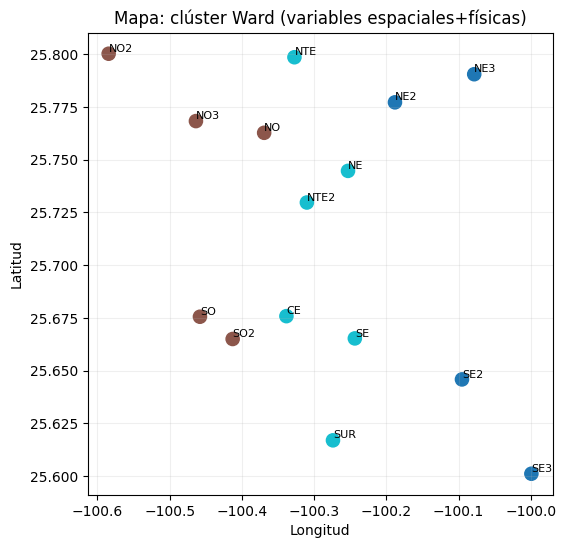

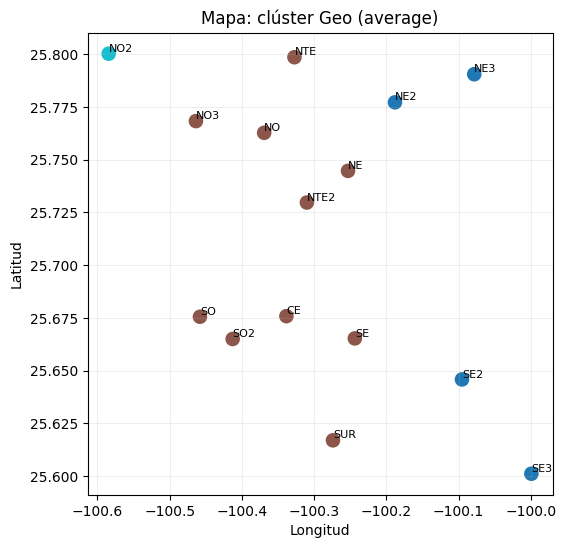

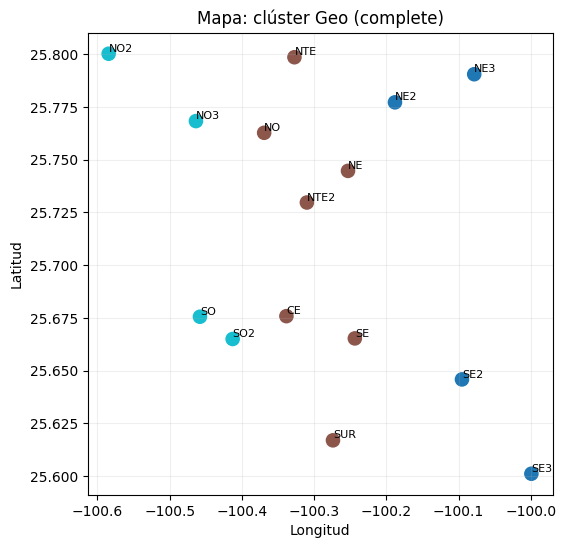

In [39]:
import matplotlib.pyplot as plt

def plot_map(label_col, title):
    plt.figure(figsize=(6,6))
    sc = plt.scatter(df["lon"], df["lat"], s=90, c=df[label_col], cmap="tab10")
    for _, r in df.iterrows():
        plt.text(r["lon"], r["lat"], r["station"], fontsize=8, ha="left", va="bottom")
    plt.xlabel("Longitud"); plt.ylabel("Latitud")
    plt.title(title); plt.grid(alpha=0.2); plt.show()

plot_map("cluster_ward_multi", "Mapa: clúster Ward (variables espaciales+físicas)")
plot_map("cluster_geo_avg", "Mapa: clúster Geo (average)")
plot_map("cluster_geo_compl", "Mapa: clúster Geo (complete)")
